# Song Segmentation Demo

## Introduction

This notebook presents an algorithm for song segmentation roughly following [1].

There are two main strands of structural segmentation: segmentation based on detecting repeated sections, and segmentation based on detecting local change.

The algorithm presented in [1], relying on chroma features, is based on detecting repetition, but with a different input feature and parameters it could pick up local change as well. It performed very well in the 2012 MIREX segmentation task, and several more recent competitive models are based on it.

The main difference between below implementation and [1] is that we take, as an input, pre-computed, beat-aligned chroma features (e.g., the echo nest's pitch features) instead of computing our own HPCP features.

---
[1] Serra, J., Müller, M., Grosche, P., & Arcos, J. L. (2012). Unsupervised detection of music boundaries by time series structure features. In: 26th AAAI Conference on Artificial Intelligence (pp. 1613–1619).

## Dependencies

In [2]:
%pylab inline
import scipy.signal as dsp
import scipy.spatial.distance as dist
from pandas import read_csv
from scipy.ndimage.morphology import grey_dilation

Populating the interactive namespace from numpy and matplotlib


## Data I/O

Below functions provide the necessary interfacing with a local dataset of beat-aligned chroma features.

We use 10 example chroma files from the Million Song Dataset (specifically, the beat-aligned pitch features for the first 10 songs in the Second Hand Song dataset, minus duplicate recordings - see http://labrosa.ee.columbia.edu/millionsong/secondhand and http://www.montefiore.ulg.ac.be/~josmalskyj/code.php for data and code).

In [3]:
example_uris = ['TRAAABD128F429CF47', 'TRAAAZF12903CCCF6B', 'TRAABYW128F4244559', 'TRAACLF128F1461E73',
                'TRAACSL128F93462F4', 'TRAADOF12903CAA1C1', 'TRAAEEH128E0795DFE', 'TRAAEJH128E0785506',
                'TRAAEOT128F14681B9', 'TRAAETC12903CC4839']

# test
n_example = 0  # choose any in 0...9
example_uri = example_uris[n_example]
print example_uri

TRAAABD128F429CF47


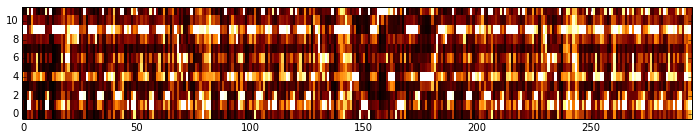

In [4]:
def load_chroma(uri):
    """Load chroma file from example collection.
    """
    chroma_file = 'data/' + uri + '.csv'
    chroma_data = read_csv(chroma_file)
    return chroma_data.values


# test
chroma_example = load_chroma(example_uri)
fig, ax = subplots(1, figsize=(12,2))
ax.imshow(chroma_example.T, origin='lower', interpolation='nearest', aspect='auto', cmap='afmhot');

(plotted sideways for visibility)

## Segmentation

The segmentation procedure we use here involves 5 steps:
1. Computing chroma delay coordinates
1. Computing a recurrence matrix from the chroma delay coordinates
1. Computing structure features from the recurrence matrix
1. Computing a novelty curve from the structure features
1. Computing structural boundaries by finding peaks in the novelty curve

### 1. delay coordinates

We use delay coordinates to construct a chroma time series that includes, with each frame, a short history of prior chroma frames.

Delay coordinates are a higher-dimensional embedding of a (multidimensional) feature that facilitate the modelling of recurrence and other non-linear behaviour of a time series.
They are found by simply concatenating to each frame, a set of `embedding_dimension` prior frames, spaced `tau` frames apart.

In [5]:
def delay_coordinates(X, embedding_dimension=4, delay=1):
    """Delay coordinates from a multidimensional feature.
    
    Args:
        X (nd-array): multidimensional input feature with rows as frames
        embedding_dimension (int): number of delays per dimension of X
            (default: 1)
        tau (int): number of frames of delay between successive
            embedding dimensions (default: 1)
    
    Returns:
        nd-array: X extended with delayed dimensions
    """
    if embedding_dimension > 1:
        delays = delay*np.arange(embedding_dimension)
        X_delays = [X[max(delays)-d:-d-max(delays), :] for d in delays]
        X_dc = np.hstack(X_delays)
    else:
        X_dc = X
        
    return X_dc


# test
dc_example = delay_coordinates(chroma_example)
print chroma_example.shape, dc_example.shape

(295, 12) (289, 48)


### 2. recurrence matrix

An essential part of Serra's successful segmentation strategy is their simple but effective similarity matrix, a binary 'recurrence matrix'. Each row in the recurrence matrix has a fixed number of ones, corresponding to the `k` closest frames to that row's frame in the feature space.

`k` is fixed to `kappa * N` where `N` is the length of the feature time series.

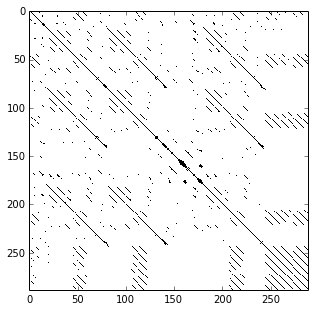

In [6]:
def recurrence_matrix(X, dist_metric='euclidean', kappa=0.04,
                      enforce_mutuality=True):
    """Recurrence matrix using Serra's k neighbours approach (2009)
    
    Args:
        X (nd-array): multidimensional input time series with rows as frames
        dist_metric (str): distance metric passed to scipy's pdist
            (default: euclidean) - see: scipy.spatial.distance.pdist
        kappa (float): number of neighbours per frame, as a fraction of N
            where N is the length of time series X (default: 0.04)
        
    Returns:
        nd-array: recurrence matrix
        
    References:
        Serrà, J., Serra, X., & Andrzejak, R. G. (2009). Cross recurrence
            quantification for cover song identification. New Journal of
            Physics, 11 (9). 
    """
    # self-distance matrix
    SDM = dist.squareform(dist.pdist(X, dist_metric))
    
    # recurrence matrix from self-distance matrix
    # by allowing a fixed number of neighbours k
    k = int(kappa * SDM.shape[0]) + 1
    RM = np.zeros_like(SDM)
    for i, row in enumerate(SDM):
        RM[i, np.argsort(row)[:k]] = 1

    # enforce neighbour mutuality:
    # RM[i,j] = 1 <=> X[i] neighbor of X[j] and X[j] neighbor of X[i]
    if enforce_mutuality:
        RM = RM * RM.T
        
    return RM


# test
recurrence_example = recurrence_matrix(dc_example)
fig, ax = subplots(1, figsize=(5,5))
ax.imshow(-recurrence_example, interpolation='nearest', cmap='afmhot');

### 3. structure features

From the recurrence matrix, 'structure features' are computed.

Structure features are a time-lag representation of the recurrence matrix. Smoothing is applied to emphasize the vertical lines that correspond to repetitions in the feature time series.

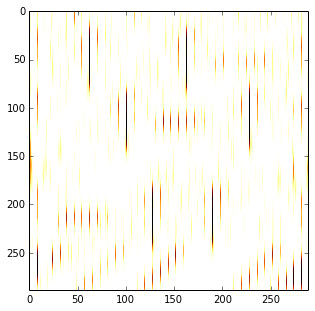

In [7]:
def structure_features(RM, s_t=48, s_l=1, sigma=0.16):
    """Compute structure features from a recurrence matrix
        as proposed by Serra et al. (2012).
    
    Args:
        RM (nd-array): recurrence matrix
        s_t (int): length of smoothing kernel along the time axis (in frames)
        s_l (int): width of smoothing kernel along the lag axis (in frames)
        sigma (float): standard deviation of the gaussian kernel (in frames)
        
    Returns:
        nd-array: structure features
    
    References:
        Serra, J., Müller, M., Grosche, P., & Arcos, J. L. (2012).
            Unsupervised detection of music boundaries by time series
            structure features. In: 26th AAAI Conference on
            Artificial Intelligence (pp. 1613–1619).
    """
    # lag matrix
    lag = np.empty_like(RM)
    for i, row in enumerate(RM):
        lag[i] = np.roll(row, -i)
    
    # gaussian smoothing
    sigma_t, sigma_l = sigma*s_t, sigma*s_l
    g_t = dsp.gaussian(s_t, std=sigma_t).reshape(-1,1)
    g_l = dsp.gaussian(s_l, std=sigma_l).reshape(1,-1)
    gaussian_kernel = g_t.dot(g_l)
    sf = dsp.convolve2d(lag, gaussian_kernel, mode='same')
    
    return sf


# test
sf_example = structure_features(recurrence_example)
fig, ax = subplots(1, figsize=(5,5))
ax.imshow(-sf_example, interpolation='nearest', aspect='auto', cmap='afmhot');

### 4. novelty curve

From the structure features, compute a novelty curve similar to those used in state-based segmentation algorithms.

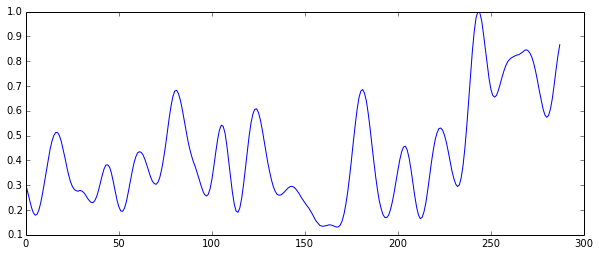

In [8]:
def novelty_curve(X):
    """Novelty curve from a multidimensional time series.
    
    Args:
        X (nd-array): multidimensional input time series with rows as frames
            
    Returns:
        1d-array: novelty curve
    """
    X_diff = np.diff(X, axis=0)
    novelty = np.linalg.norm(X_diff, axis=1)**2
    return novelty / np.max(novelty)


# test
novelty_example = novelty_curve(sf_example)
fig, ax = subplots(1, figsize=(10,4))
ax.plot(novelty_example);

### 5. boundaries 

Finally, boundaries are found by locating prominent peaks in the novelty curve.

Peaks are selected based on two criteria: it must be above a certain threshold `peak_thr`, and corresponds to the global maximum of a window of length `2 * min_distance` centered at the peak.

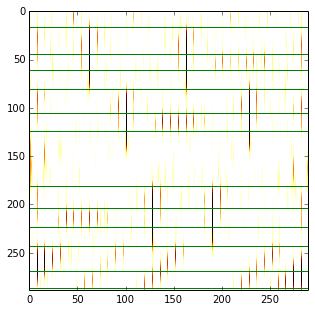

In [9]:
def novelty_curve_peaks(novelty, min_distance=12, peak_thr=0.05):
    """Find peaks in a novelty curve.
    
    Args:
        novelty (1d-array): novelty curve
        min_distance (int): minimum distance between peaks
        peak_thr: peak height threshold relative to max(novelty)
        
    Returns:
        1d-array: peak locations in frames
    """
    novelty_dil = grey_dilation(novelty, size=(2*min_distance,))
    peaks = np.where(np.logical_and(novelty == novelty_dil, novelty > peak_thr))[0]
    
    return peaks


def plot_boundaries(X, boundaries=[], ax=matplotlib.pyplot, cmap='afmhot', fmt='g'):
    """Plot structural boundaries over a multidimensional time series
    
    Args:
        X (nd-array): multidimensional input time series with rows as frames
        boundaries (list or 1d-array): structural boundaries
        ax (pyplot axis): pyplot axis on which to plot
        cmap (str): pyplot colormap for plotting X (default: 'afmhot')
        fmt (str): pyplot format string for plotting boundaries (default: 'g')
    """
    vis_boundaries = np.tile(np.array(boundaries).reshape((1,-1)), (2,1))
    vis_t = np.tile(np.array([[0, X.shape[1]]]).T, len(boundaries))
    
    ax.imshow(X, interpolation='nearest', aspect='auto', cmap='afmhot');
    ax.plot(vis_t, vis_boundaries, fmt);
    ax.autoscale(tight=True)
    
    
# test
boundaries_example = novelty_curve_peaks(novelty_example)
fig, ax = subplots(1, figsize=(5,5))
plot_boundaries(-sf_example, boundaries_example, ax=ax)

## Overview

Below script gives a complete overview of the above pipeline, with specification of all relevant parameters. Tinker away.

As to parameter names, we follow the paper, unless a more common term exists (e.g., `embedding_dimension` rather then `m`).

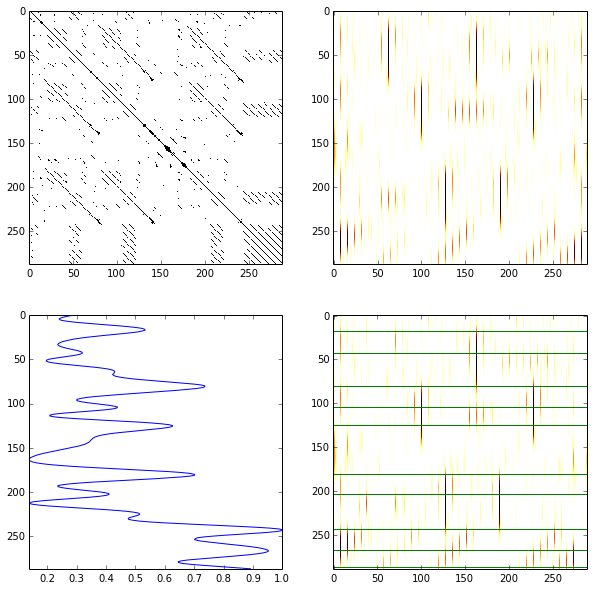

In [11]:
n_example = 0
example_uri = example_uris[n_example]

# set parameters

embedding_dimension = 4    # serra: embedding_dimension = m = 4 (though at hop_length 0.14 s)
delay = 1                  # serra: delay = tau = 1
dist_metric = 'euclidean'  # serra: 'euclidean'
kappa = 0.04               # serra: 0.04
s_t, s_l = 60, 1           # serra: 30 s, 0.3 s ~ 60 beats, 1 beat
min_distance = 12          # serra: lambda = 2 x min_distance = 12 s => min_distance ~ 12 beats
peak_thr = 0.05            # serra: 0.05

# load pre-computed chroma features

chroma_example = load_chroma(example_uri)

# compute boundaries

dc_example = delay_coordinates(chroma_example, embedding_dimension=embedding_dimension, delay=delay)

recurrence_example = recurrence_matrix(dc_example, dist_metric=dist_metric, kappa=kappa)

sf_example = structure_features(recurrence_example, s_t=s_t, s_l=s_l)

novelty_example = novelty_curve(sf_example)

boundaries_example = novelty_curve_peaks(novelty_example, min_distance=min_distance, peak_thr=peak_thr)

# plot results

fig, ax = subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(-recurrence_example, interpolation='nearest', aspect='auto', cmap='afmhot');
ax[0,1].imshow(-sf_example, interpolation='nearest', aspect='auto', cmap='afmhot');

ax[1,0].plot(novelty_example, np.arange(len(novelty_example)));
ax[1,0].invert_yaxis()
ax[1,0].autoscale(tight=True)

plot_boundaries(-sf_example, boundaries_example, ax=ax[1,1])

## Closing notes

Several steps for a complete segmentation are not included here, such as conversion of boundary times in frames to boundary times in seconds (requires the echo nest beat times), as well as a proper evaluation.

With more time, an evaluation would be useful, as well as more proper formal testing of the functions and provisions for edge cases (implementing the right assertions and exceptions).